# SYNTHETIC EXAMPLE FOR LOW RANK DIFFERENTIAL EQUATION APPROXIMATION

We start by importing the librairies

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation as animation
import matplotlib.pyplot as plt
%matplotlib inline
from celluloid import Camera
from scipy.linalg import expm, sinm, cosm

This notebook uses this sources : 

**1)**_Projection Methods for Dynamical Low-Rank Approximation of High-Dimensional Problems_

Emil Kieri and Bart Vandereycken
https://www.degruyter.com/view/journals/cmam/19/1/article-p73.xml

**2)**_Streaming Low-Rank Matrix Approximation with an Application to Scientific Simulation_
​
Joel A. Tropp, Alp Yurtsever, Madeleine Udell, Volkan Cevher
https://arxiv.org/pdf/1902.08651.pdf
​

We want to compute a synthetic example (see source [1]) to test if the low rank approximation algorithm works in differential equation case. We already know the solution to the problem, which is : 

$$A(t)=e^{t \Omega_{1}} e^{t D} e^{t \Omega_{2}}$$

with $0 \leq t \leq 1$ and $\Omega_{1}, \Omega_{2}$ two random skew-symmetric matrices of size $n \times n$

The derivative at t is : 

$$dA(t)=\Omega_{1} e^{t \Omega_{1}} e^{t D} e^{t \Omega_{2}}+e^{t \Omega_{1}} D e^{t D} e^{t \Omega_{2}} + e^{t \Omega_{1}} e^{t D} \Omega_{2}  e^{t \Omega_{2}}$$

We now define the two function **A_t** & **dA_t**

In [58]:
def A_t(t):
    e_1=expm(t*O_1)
    e_2=expm(t*O_2)
    e_d=expm(t*D)
    A_t=e_1@e_d@e_2
    
    return A_t

def dA_t(t):
    
    e_1=expm(t*O_1)
    e_2=expm(t*O_2)
    e_d=expm(t*D)
    dA_t=O_1@e_1@e_d@e_2+e_1@D@e_d@e_2+e_1@e_d@O_2@e_2
    
    return dA_t

_remark : we need to use expm instead of np.exp for the matrices case_

We then define the solver (Euler and RK4)

**Euler**

$A_{n+1}=A_{n}+h*dA_{n}$

$A_0=A_{init}$

In [59]:
def Euler_Solver(func, Ainit, t_range, h):
    #Description = solve the problem F(A)=dA with the Euler Scheme
    #Inputs = func : function to evaluate, Ainit : A initial, t_range : range for t, h : step size
    #Ouputs = tsol : time sol, Asol : solution at Y
    

    #-------------------------------- initialisation
    
    n = int((t_range[-1] - t_range[0])/h) #number of step
    

    #--------------------------------- 0 step
    
    Asol=[]
    Asol.append(Ainit) #0 step
    
    tsol=[]
    tsol.append(t_range[0])
    
    #----------------------------------- calcul
    
    for i in range(n):
        
        A=Asol[i]
        t=tsol[i]
        
        dA = dA_t(t) # Evaluates dy/dx
                
        Asol.append(Asol[i]+dA*h) #Euler
                          
        t += h # Increase x-step
        
        tsol = np.append(tsol, t) 
        
    
    return([tsol,Asol])

**RK4**

$A_{n+1}=A_{n}+h*(k_{1} / 6+k_{2} / 3+k_{3} / 3+k_{4} / 6)$

$A_0=A_{init}$

$k_{1}=dA(t_n)$

$k_{2}=dA(t_n+\frac{h}{2})+\frac{h}{2}*k1$

$k_{3}=dA(t_n+\frac{h}{2})+\frac{h}{2}*k2$

$k_{4}=dA(t_n+h)+h*k3$

In [85]:
def rk4_Solver(func, Ainit, t_range, h):
    #Description : Given a func, Ainit, t_range,the time step h,
    #return the approximed solution (Ysol) 
    #corresponding to the time solution (tsol) using Runge Kunta order 4
    #Inputs : func = fonction, Ainit = A initial, t_range = time range, h = time step
    #Outputs : tsol, Ysol = solution at tsol

    #-------------------------------- initialisation
    
    
    Asol=[]
    Asol.append(Ainit) #0 step
    
    tsol=[]
    tsol.append(t_range[0])
    
    
    #----------------------------------- Runge Kunta
    
    for i in range(n):
        
        A=Asol[i]
        t=tsol[i]
        
        #---------------------- weight
        
        k1=dA_t(t)
        k2=dA_t(t+h/2)+(h/2)*k1
        k3=dA_t(t+h/2)+(h/2)*k2
        k4=dA_t(t+h)+h*k3
        
        
        approx=A+(h/6)*(k1+2*k2+2*k3+k4) #RK4 shema

        
        Asol.append(approx)
                              
        t += h # Increase x-step
        
        tsol = np.append(tsol, t)   
        
    return([tsol,Asol])

We now compute the result for these normal solver : 

We initiate the parameters : 

In [86]:
#---------------- nxn and epsilon for diagonal

n=100
eps=10**-6

size=(n,n)

eps

d=np.linspace(eps,1,n)
d=d[::-1]
d=[10**d[i] for i in range(100)]
D=np.diagflat(d)

#---------------- omega 1 and omega 2 

O_1 = np.random.random(size) ; O_1=1/2*(O_1-np.transpose(O_1)) #generating a skew symetric matrix
O_2 = np.random.random(size) ; O_2=1/2*(O_2-np.transpose(O_2)) #generating a skew symetric matrix

Then we compute the relative error 

In [87]:
Ainit = A_t(0)

h=0.001

[ts1,ys1]=Euler_Solver(dA_t, Ainit, [0,1], h)
[ts2,ys2]=rk4_Solver(dA_t, Ainit, [0,1], h)


#Exact
ts0=ts1
ys0=[]

for i in range(len(ts0)):
    a=A_t(i*h)
    ys0.append(a)
    
err1=[np.linalg.norm(ys1[i]-ys0[i],'fro')/np.linalg.norm(ys0[i],'fro') for i in range(n)]
err2=[np.linalg.norm(ys2[i]-ys0[i],'fro')/np.linalg.norm(ys0[i],'fro') for i in range(n)]

Now we plot the error

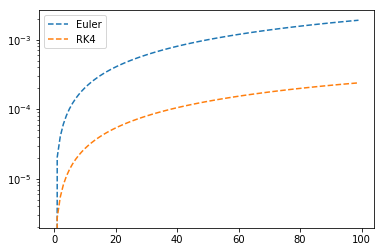

In [88]:
plt.semilogy(err1,'--', label='Euler')
plt.semilogy(err2,'--', label='RK4')
plt.legend()

#plt.title('Relative error $R_F$ for each points of the discretized space')


We now want to test if the method is consistent by changing the h and seeing how the error at each step behaves

In [90]:
hstart=0.01

err_h_1=[]
err_h_2=[]

size=Ainit.shape

factor=size[0]*size[1]

h_vec=[]

for i in range(6):
    
    h=hstart/(2**i)
    
    #Exact
    
    ts0=ts1
    ys0=[]
    
    for i in range(len(ts0)):
        
        a=A_t(i*h)
        ys0.append(a)
    
    [ts1,ys1]=Euler_Solver(dA_t, Ainit, [0,1], h)
    [ts2,ys2]=rk4_Solver(dA_t, Ainit, [0,1], h)
        
    moy1=np.sum(np.abs(ys1[1]-ys0[1]))/factor #moyenne par pour chaque point
    moy2=np.sum(np.abs(ys2[1]-ys0[1]))/factor #idem
    
    err_h_1.append(moy1*h)
    err_h_2.append(moy2*h)
    
    h_vec.append(h**4)



Plotting the result 

Text(0,0.5,'Mean Error by step')

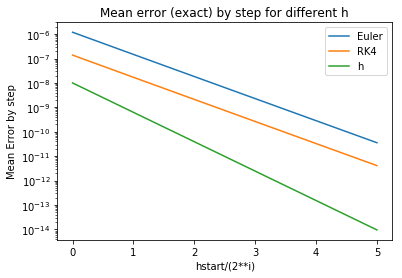

In [91]:
plt.semilogy(err_h_1,label='Euler')
plt.semilogy(err_h_2,label='RK4')
plt.semilogy(h_vec, label='h')


plt.legend()
plt.title('Mean error (exact) by step for different h')
plt.xlabel('hstart/(2**i)')
plt.ylabel('Mean Error by step')

Now we want to change the solvers to approximate the result at each iteration by using a low rank algorithm. We will use the STA algorithm (see source [2])

In [92]:
def sta(r,A,k,s):
    #INPUTS:
    #r : truncated final rank
    #A : matrix to approximate (MxN)
    #Dim_redux : (KxM), (KxN), (SxM), (SxN)
    #OUTPUTS : 
    #A_tilda : approximate matrix of rank r0
    #////plan
    #1. recuperation of the dim_red from the array
    #2. capturing the range, corange, and the new whole 
    #3. qr to get the orthonormal matrix
    #4. least square
    #5. reconstruct the svd after troncature
    #6. reconstruction
    
    #1. recuption of the dim_red from the array and initiation of X,Y,Z,W
    #(KxM), (KxN), (SxM), (SxN)
    
    m,n =A.shape
    Y_=np.random.randn(k,m) ; Ω=np.random.randn(k,n) ; Φ=np.random.randn(s,m) ; Ψ=np.random.randn(s,n)
    
    #2. capturing the range, corange, and the new whole 
    
    X=Y_@A ; Y=A@Ω.conj().T ; Z=Φ@A@(Ψ.conj().T) ; 
    
    #3. qr 
    
    Q=np.linalg.qr(Y)[0] ; P=np.linalg.qr(X.conj().T)[0]
    
    #4. least square
    
    C=np.linalg.lstsq(Φ@Q,Z, rcond=None)[0]
    C=(np.linalg.lstsq(Ψ@P,C.conj().T, rcond=None)[0]).conj().T
    
    #5. troncated svd + consolidation
    
    S, D, Vt=np.linalg.svd(C, full_matrices=True)
    S=S[:,0:r] ; D=np.diag(D[0:r]) ; Vt=Vt[0:r,:]
    S=Q@S ; Vt=Vt@(P.conj().T)
    
    #6. reconstruction
    
    Trunc_svd=[S,D,Vt]
    A_tilda=S@D@Vt
    
    return(A_tilda, Trunc_svd)

Now we define both solvers

In [93]:
def Euler_Solver_sta(func, Ainit, t_range, h,r,k,s):
    #Description = solve the problem F(A)=dA with the Euler Scheme
    #Inputs = func : function to evaluate, Ainit : A initial, t_range : range for t, h : step size,
    #r : aimed rank for each approximation, k,s : parameters for sta
    #Ouputs = tsol : time sol, Asol : solution at Y
    

    #-------------------------------- initialisation
    
    n = int((t_range[-1] - t_range[0])/h) #number of step
    

    #--------------------------------- 0 step
    
    Asol=[]
    Asol.append(sta(r,Ainit,k,s)[0]) #0 step
    
    tsol=[]
    tsol.append(t_range[0])
    
    #----------------------------------- calcul
    
    for i in range(n):
        
        A=Asol[i]
        t=tsol[i]
        
        dA = dA_t(t) # Evaluates dy/dx
        
        approx=Asol[i]+dA*h
                
        Asol.append(sta(r,approx,k,s)[0]) #Euler
                          
        t += h # Increase x-step
        
        tsol = np.append(tsol, t) 
        
    
    return([tsol,Asol])

In [94]:
def rk4_Solver_sta(func, Ainit, t_range, h,r,k,s):
    #Description : Given a func, Ainit, t_range,the time step h,aimed rank r, parameters k,s
    #return the approximed solution (Ysol) 
    #corresponding to the time solution (tsol) using Runge Kunta order 4
    #Inputs : func = fonction, Ainit = A initial, t_range = time range, h = time step
    #Outputs : tsol, Ysol = solution at tsol

    #-------------------------------- initialisation
    
    
    Asol=[]
    Asol.append(sta(r,Ainit,k,s)[0]) #0 step
    
    tsol=[]
    tsol.append(t_range[0])
    
    
    #----------------------------------- Runge Kunta
    
    for i in range(n):
        
        A=Asol[i]
        t=tsol[i]
        
        #---------------------- weight
        
        k1=dA_t(t)
        k2=dA_t(t+h/2)+(h/2)*k1
        k3=dA_t(t+h/2)+(h/2)*k2
        k4=dA_t(t+h)+h*k3
        
        
        approx=A+(h/6)*(k1+2*k2+2*k3+k4) #RK4 shema

        
        Asol.append(sta(r,approx,k,s)[0])
                              
        t += h # Increase x-step
        
        tsol = np.append(tsol, t)   
        
    return([tsol,Asol])

_Remark : On the interval [0,1], the matrix doesn't have a strong decaying singular value, which induces extremely weak result for any low rank algorithm. The result were obtaining by testing the singular value of these matrices_

In [95]:
print(np.linalg.svd(A_t(0))[1])
print(np.linalg.svd(A_t(0.1))[1])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
[2.71828183 2.65650136 2.59749755 2.54111615 2.48721309 2.43565372
 2.38631211 2.33907037 2.2938181  2.25045181 2.20887444 2.1689949
 2.13072764 2.09399228 2.05871322 2.02481933 1.99224365 1.9609231
 1.93079821 1.90181291 1.87391427 1.84705232 1.82117984 1.79625222
 1.77222724 1.74906497 1.72672759 1.70517929 1.68438611 1.66431586
 1.64493802 1.62622359 1.60814505 1.59067625 1.57379234 1.55746968
 1.5416858  1.52641928 1.51164975 1.49735781 1.48352494 1.47013352
 1.45716672 1.44460849 1.43244351 1.42065714 1.40923541 1.39816496
 1.38743301 1.37702735 1.36693629 1.35714864 1.34765371 1.33844122
 1.32950135 1.32082468 1.31240217 1.30422518 1.29628538 1.28857479
 1.28108578 1.27381097 1.2

In [96]:
Ainit = A_t(0)

[ts1,ys1]=Euler_Solver(dA_t, Ainit, [0,1], h)
[ts2,ys2]=rk4_Solver(dA_t, Ainit, [0,1], h)
[ts3,ys3]=Euler_Solver_sta(dA_t, Ainit, [0,1], h,20,40,80)
[ts4,ys4]=rk4_Solver_sta(dA_t, Ainit, [0,1], h,20,40,80)


#Exact
ts0=ts1
ys0=[]

for i in range(len(ts0)):
    a=A_t(i*h)
    ys0.append(a)

err1=[np.linalg.norm(ys1[i]-ys0[i],'fro')/np.linalg.norm(ys0[i],'fro') for i in range(n)]
err2=[np.linalg.norm(ys2[i]-ys0[i],'fro')/np.linalg.norm(ys0[i],'fro') for i in range(n)]
err3=[np.linalg.norm(ys3[i]-ys0[i],'fro')/np.linalg.norm(ys0[i],'fro') for i in range(n)]
err4=[np.linalg.norm(ys4[i]-ys0[i],'fro')/np.linalg.norm(ys0[i],'fro') for i in range(n)]

Text(0.5,1,'Low-rank approximation for interval [0,1]')

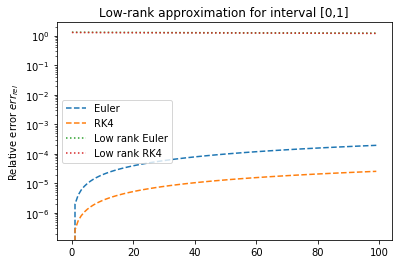

In [100]:
plt.semilogy(err1,'--', label='Euler')
plt.semilogy(err2,'--',label='RK4')
plt.plot(err3, ":", label='Low rank Euler')
plt.plot(err4, ":",label='Low rank RK4')
plt.legend()
plt.legend()
plt.ylabel('Relative error $err_{rel}$')
plt.title('Low-rank approximation for interval [0,1]')

array([2.20264658e+04, 1.75025139e+04, 1.39814260e+04, 1.12265200e+04,
       9.06003633e+03, 7.34776813e+03, 5.98787123e+03, 4.90267250e+03,
       4.03264282e+03, 3.33194003e+03, 2.76509654e+03, 2.30454562e+03,
       1.92876540e+03, 1.62087964e+03, 1.36759824e+03, 1.15841129e+03,
       9.84973433e+02, 8.40631437e+02, 7.20060331e+02, 6.18981854e+02,
       5.33945815e+02, 4.62159593e+02, 4.01354698e+02, 3.49681923e+02,
       3.05628665e+02, 2.67953493e+02, 2.35634181e+02, 2.07826289e+02,
       1.83830049e+02, 1.63063786e+02, 1.45042534e+02, 1.29360759e+02,
       1.15678374e+02, 1.03709363e+02, 9.32125244e+01, 8.39838958e+01,
       7.58505461e+01, 6.86654742e+01, 6.23034033e+01, 5.66573045e+01,
       5.16355159e+01, 4.71593489e+01, 4.31610939e+01, 3.95823555e+01,
       3.63726581e+01, 3.34882761e+01, 3.08912495e+01, 2.85485548e+01,
       2.64314032e+01, 2.45146472e+01, 2.27762764e+01, 2.11969887e+01,
       1.97598253e+01, 1.84498577e+01, 1.72539214e+01, 1.61603864e+01,
      

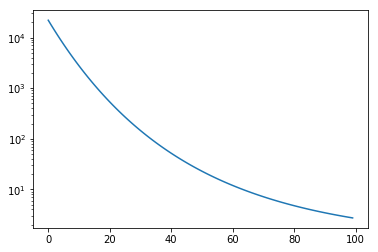

In [98]:
plt.semilogy(np.linalg.svd(A_t(1))[1])
np.linalg.svd(A_t(1))[1]

Now we want to compare them to the error by the exact version (without low rank approximation) on the interval [3,4]

In [114]:
interval=[3,4]
Ainit = A_t(interval[0])

[ts1,ys1]=Euler_Solver(dA_t, Ainit, interval, h)
[ts2,ys2]=rk4_Solver(dA_t, Ainit, interval, h)
[ts3,ys3]=Euler_Solver_sta(dA_t, Ainit, interval, h,20,40,80)
[ts4,ys4]=rk4_Solver_sta(dA_t, Ainit, interval, h,20,40,80)


#Exact
ts0=ts1
ys0=[]

for i in range(len(ts0)):
    a=A_t(3+i*h)
    ys0.append(a)

err1=[np.linalg.norm(ys1[i]-ys0[i],'fro')/np.linalg.norm(ys0[i],'fro') for i in range(n)]
err2=[np.linalg.norm(ys2[i]-ys0[i],'fro')/np.linalg.norm(ys0[i],'fro') for i in range(n)]
err3=[np.linalg.norm(ys3[i]-ys0[i],'fro')/np.linalg.norm(ys0[i],'fro') for i in range(n)]
err4=[np.linalg.norm(ys4[i]-ys0[i],'fro')/np.linalg.norm(ys0[i],'fro') for i in range(n)]

Plotting the result

Text(0.5,1,'Low-rank approximation for the interval $[3,4]$, target rank r=$20$')

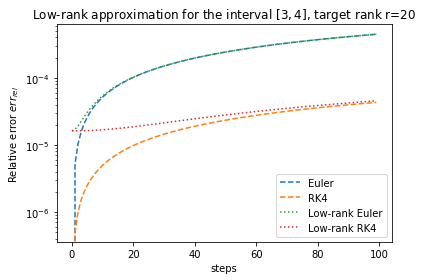

In [115]:
plt.semilogy(err1,"--", label='Euler')
plt.semilogy(err2,"--", label='RK4')
plt.plot(err3, ":", label='Low-rank Euler')
plt.plot(err4, ":",label='Low-rank RK4')
plt.legend()
plt.legend()
plt.ylabel('Relative error $err_{rel}$')
plt.xlabel('steps')
plt.title('Low-rank approximation for the interval $[3,4]$, target rank r=$20$')

Now we want to compare the result of this experiment with others low rank algorithme (see source [2] for more information on how to implement the algorithm)

We implement the exact svd of rank r **svd_r**, the **tcyu** algorithm and the **hmt** algorithm

In [103]:
def svd_r(A,r):
    #INPUTS : 
    #A = matrix to troncate
    #r = rank 
    #OUTPUT : 
    #M = matrix final 
    
    U,D,Vt = np.linalg.svd(A, full_matrices=True)
    U=U[:,0:r] ; Vt=Vt[0:r,:] ; D=np.diag(D[0:r])
    finale=U@D@Vt
    
    return(finale)

In [104]:
def hmt_fixed_r(M,r,k,q):
    #INPUTS : 
    #M = Matrix MxN to approximate
    #r = final rank
    #k = dim redux size
    #q = parameter (0,1,2)
    #OUTPUTS : 
    #M_r = Matrix with approximated rank
    #U_r = troncated singular vector matrix
    
    m=M.shape[0]
    n=M.shape[1]

    Omega=np.random.randn(n,k)
    
    if q==0:
        
        Y=M@Omega
    
    if q==1:
        
        Y=M@(M.conj().T@(M@Omega))
        
    if q==2:
        
        Y=M@(M.conj().T@(M@(M.conj().T@(M@Omega))))
             
    Q,R=np.linalg.qr(Y)
        
    B=Q.conj().T@M
        
    U,D,Vh=np.linalg.svd(B,full_matrices=True)
    
    U=U[:,0:r]
    
    D=D[0:r]
    
    Vh=Vh[0:r,:]

    U=Q@U
        
    M_r=U@np.diagflat(D)@Vh
        
    U_r=U
    
    return(M_r,U_r)

In [105]:
def tcyu(M,r,k,l):
    #INPUTS : 
    #M = matrix to approximate
    #r = wanted rank
    #k,l = k<l (parameter)
    #OUTPUTS : 
    #M_tilde = wanted matrix
    
    m=M.shape[0]
    n=M.shape[1]
    
    Y_tilde=np.random.randn(l,m)
    Ω=np.random.randn(k,n)
    
    X=Y_tilde@M
    Y=M@(Ω.conj().T)
    
    Q, R=np.linalg.qr(Y)
    
    B=np.linalg.lstsq(Y_tilde@Q, X,rcond=None)[0]
    
    U, D, Vh = np.linalg.svd(B, full_matrices=True)
    
    U=U[:,0:r] ; D=D[0:r] ; Vh=Vh[0:r,:]
    
    Q_tilde=Q@U
    
    M_tilde=U@np.diagflat(D)@Vh
    
    M_tilde=Q@M_tilde
    
    return(M_tilde,Q_tilde)

And we define the corresponding RK4 solver. We don't do the Euler case as it's less interesting. 

In [106]:
def rk4_Solver_svd_exact(func, Ainit, t_range, h,r):
    #Description : Given a func, Ainit, t_range,the time step h,aimed rank r
    #return the approximed solution (Ysol) 
    #corresponding to the time solution (tsol) using Runge Kunta order 4
    #Inputs : func = fonction, Ainit = A initial, t_range = time range, h = time step
    #Outputs : tsol, Ysol = solution at tsol

    #-------------------------------- initialisation
    
    
    Asol=[]
    Asol.append(svd_r(Ainit,r)) #0 step
    
    tsol=[]
    tsol.append(t_range[0])
    
    
    #----------------------------------- Runge Kunta
    
    for i in range(n):
        
        A=Asol[i]
        t=tsol[i]
        
        #---------------------- weight
        
        k1=dA_t(t)
        k2=dA_t(t+h/2)+(h/2)*k1
        k3=dA_t(t+h/2)+(h/2)*k2
        k4=dA_t(t+h)+h*k3
        
        
        approx=A+(h/6)*(k1+2*k2+2*k3+k4) #RK4 shema

        
        Asol.append(svd_r(approx,r))
                              
        t += h # Increase x-step
        
        tsol = np.append(tsol, t)   
        
    return([tsol,Asol])

In [107]:
def rk4_Solver_hmt(func, Ainit, t_range, h,r,k,q):
    #Description : Given a func, Ainit, t_range,the time step h,aimed rank r, k is the dim redux size
    #and q is the parameter for hmt low rank algorithm
    #return the approximed solution (Ysol) 
    #corresponding to the time solution (tsol) using Runge Kunta order 4
    #Inputs : func = fonction, Ainit = A initial, t_range = time range, h = time step
    #Outputs : tsol, Ysol = solution at tsol

    #-------------------------------- initialisation
    
    
    Asol=[]
    Asol.append(hmt_fixed_r(Ainit,r,k,q)[0]) #0 step
    
    tsol=[]
    tsol.append(t_range[0])
    
    
    #----------------------------------- Runge Kunta
    
    for i in range(n):
        
        A=Asol[i]
        t=tsol[i]
        
        #---------------------- weight
        
        k1=dA_t(t)
        k2=dA_t(t+h/2)+(h/2)*k1
        k3=dA_t(t+h/2)+(h/2)*k2
        k4=dA_t(t+h)+h*k3
        
        
        approx=A+(h/6)*(k1+2*k2+2*k3+k4) #RK4 shema

        
        Asol.append(hmt_fixed_r(approx,r,k,q)[0])
                              
        t += h # Increase x-step
        
        tsol = np.append(tsol, t)   
        
    return([tsol,Asol])

In [108]:
def rk4_Solver_tcyu(func, Ainit, t_range, h,r,k,l):
    #Description : Given a func, Ainit, t_range,the time step h,aimed rank r, the parameter k
    #and l for the dim redux
    #return the approximed solution (Ysol) 
    #corresponding to the time solution (tsol) using Runge Kunta order 4
    #Inputs : func = fonction, Ainit = A initial, t_range = time range, h = time step
    #Outputs : tsol, Ysol = solution at tsol

    #-------------------------------- initialisation
    
    
    Asol=[]
    Asol.append(tcyu(Ainit,r,k,l)[0]) #0 step
    
    tsol=[]
    tsol.append(t_range[0])
    
    
    #----------------------------------- Runge Kunta
    
    for i in range(n):
        
        A=Asol[i]
        t=tsol[i]
        
        #---------------------- weight
        
        k1=dA_t(t)
        k2=dA_t(t+h/2)+(h/2)*k1
        k3=dA_t(t+h/2)+(h/2)*k2
        k4=dA_t(t+h)+h*k3
        
        
        approx=A+(h/6)*(k1+2*k2+2*k3+k4) #RK4 shema

        
        Asol.append(tcyu(approx,r,k,l)[0])
                              
        t += h # Increase x-step
        
        tsol = np.append(tsol, t)   
        
    return([tsol,Asol])

Now we want to compare the different solver against the exact solution

In [109]:
Ainit = A_t(3)

[ts1,ys1]=rk4_Solver_svd_exact(dA_t, Ainit, [3,4], h,20)
[ts2,ys2]=rk4_Solver_hmt(dA_t, Ainit, [3,4], h,20,40,0)
[ts3,ys3]=rk4_Solver_tcyu(dA_t, Ainit, [3,4], h,20,40,80)
[ts4,ys4]=rk4_Solver_sta(dA_t, Ainit, [3,4], h,20,40,80)
[ts5,ys5]=rk4_Solver(dA_t, Ainit, [3,4], h)


#Exact
ts0=ts1
ys0=[]

for i in range(len(ts0)):
    a=A_t(3+i*h)
    ys0.append(a)

err1=[np.linalg.norm(ys1[i]-ys0[i],'fro')/np.linalg.norm(ys0[i],'fro') for i in range(n)]
err2=[np.linalg.norm(ys2[i]-ys0[i],'fro')/np.linalg.norm(ys0[i],'fro') for i in range(n)]
err3=[np.linalg.norm(ys3[i]-ys0[i],'fro')/np.linalg.norm(ys0[i],'fro') for i in range(n)]
err4=[np.linalg.norm(ys4[i]-ys0[i],'fro')/np.linalg.norm(ys0[i],'fro') for i in range(n)]
err5=[np.linalg.norm(ys5[i]-ys0[i],'fro')/np.linalg.norm(ys0[i],'fro') for i in range(n)]

Now we plot the result

Text(0,0.5,'relative $err_{rel}$')

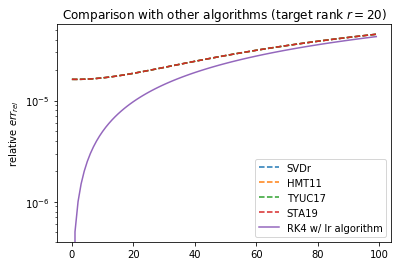

In [112]:
plt.semilogy(err1, "--", label='SVDr')
plt.semilogy(err2, "--", label='HMT11')
plt.semilogy(err3, "--", label='TYUC17')
plt.semilogy(err4, "--",label='STA19')
plt.semilogy(err5, label='RK4 w/ lr algorithm')
plt.legend()
plt.title('Comparison with other algorithms (target rank $r=20$)')
plt.ylabel('relative $err_{rel}$')